In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
import joblib

sns.set(style="whitegrid", rc={"figure.figsize": (10,5)})
np.random.seed(42)
pd.options.display.float_format = lambda x: f"{x:.4f}"

In [6]:
from sklearn.datasets import fetch_openml

d = fetch_openml("Australian", version=2, as_frame=True)  # v1 неактивна → берём v2
df = d.frame.copy()

# таргет → 1=bad (отказать), 0=good (одобрить)
s = df["class"].astype(str).str.strip().str.lower()
if set(s.unique()) <= {"+","-"}:
    y = (s == "-").astype(int)           # '-' считаем bad
elif set(s.unique()) <= {"1","0","2"}:
    # часто: 1=good, 0/2=bad
    y = s.isin(["0","2"]).astype(int)
elif set(s.unique()) <= {"yes","no"}:
    y = (s == "no").astype(int)
else:
    y = (s == "bad").astype(int)

X = df.drop(columns=["class"])

# фичи по типам
cat_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print("shape:", X.shape, "| bad rate:", y.mean().round(3))
print("num:", len(num_cols), "cat:", len(cat_cols))
display(pd.concat([X.head(), y.head().rename("target")], axis=1)))

SyntaxError: unmatched ')' (1919741427.py, line 26)

In [3]:
# 60/20/20: train/valid/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# One-Hot для категориальных (если они есть), скейл численных
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), num_cols),
        ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", ohe)]), cat_cols)
    ],
    remainder="drop"
)

In [4]:
pipe_lr = Pipeline([
    ("prep", preprocess),
    ("lr", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

pipe_lr.fit(X_train, y_train)
proba_valid = pipe_lr.predict_proba(X_valid)[:, 1]
print(f"Valid: ROC-AUC={roc_auc_score(y_valid, proba_valid):.3f}, PR-AUC={average_precision_score(y_valid, proba_valid):.3f}")

# подбор порога: FP (одобрили плохого) дороже FN (отказали хорошему)
def best_threshold_cost(y_true, proba, cost_fp=5.0, cost_fn=1.0):
    grid = np.linspace(0.05, 0.95, 181)
    y = np.asarray(y_true).astype(int); p = np.asarray(proba).astype(float)
    pred = p[:, None] >= grid[None, :]
    fp = (pred & (y[:, None] == 0)).sum(axis=0)
    fn = ((~pred) & (y[:, None] == 1)).sum(axis=0)
    return float(grid[np.argmin(cost_fp*fp + cost_fn*fn)])

thr = best_threshold_cost(y_valid, proba_valid, cost_fp=5, cost_fn=1)
thr

Valid: ROC-AUC=0.919, PR-AUC=0.907


0.625

Test: ROC-AUC=0.918, PR-AUC=0.920


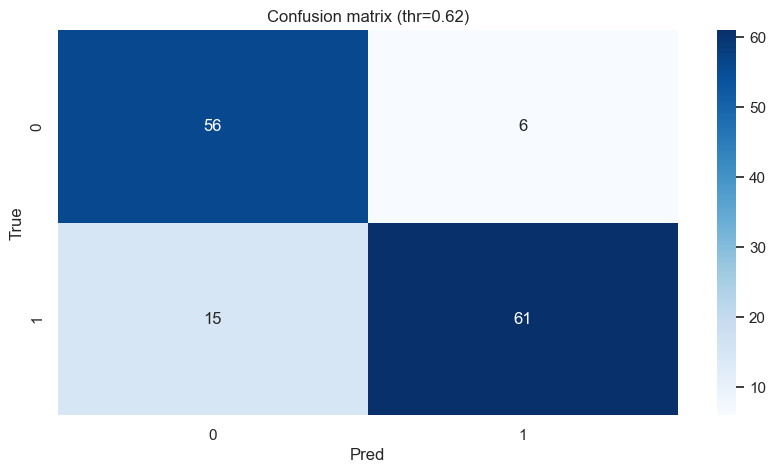

              precision    recall  f1-score   support

     good(0)       0.79      0.90      0.84        62
      bad(1)       0.91      0.80      0.85        76

    accuracy                           0.85       138
   macro avg       0.85      0.85      0.85       138
weighted avg       0.86      0.85      0.85       138



In [14]:
proba_test = pipe_lr.predict_proba(X_test)[:, 1]
pred_test = (proba_test >= thr).astype(int)

print(f"Test: ROC-AUC={roc_auc_score(y_test, proba_test):.3f}, PR-AUC={average_precision_score(y_test, proba_test):.3f}")
cm = confusion_matrix(y_test, pred_test)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion matrix (thr={thr:.2f})"); plt.xlabel("Pred"); plt.ylabel("True"); plt.show()

print(classification_report(y_test, pred_test, target_names=["good(0)","bad(1)"]))

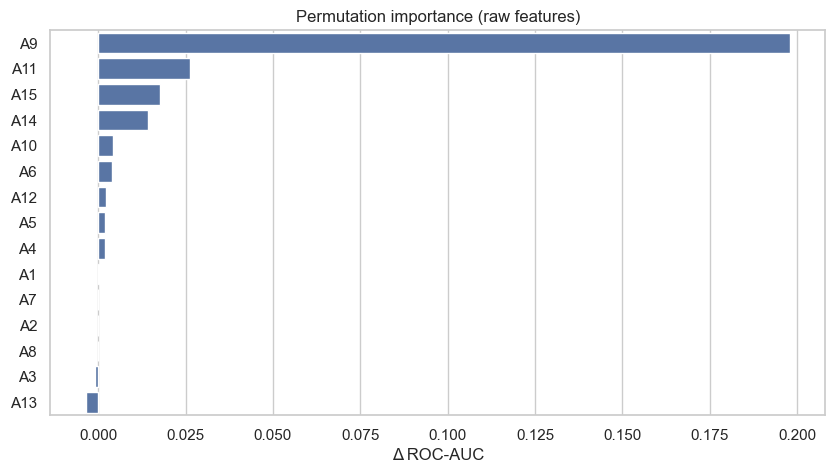

,feature,importance
8,A9,0.1980
10,A11,0.0264
14,A15,0.0177
13,A14,0.0142
9,A10,0.0044
5,A6,0.0039
11,A12,0.0024
4,A5,0.0019
3,A4,0.0019
0,A1,0.0002


In [15]:
# пермутация на "сырых" колонках, чтобы длины совпадали
r = permutation_importance(best_pipe, X_test, y_test,
                           n_repeats=30, random_state=42, scoring="roc_auc")

feat_names = X_test.columns  # если считали на Pipeline по “сырым” колонкам
imp = pd.DataFrame({
    "feature": feat_names,
    "mean": r.importances_mean,
    "std": r.importances_std
})
imp["significant"] = (imp["mean"] - 2*imp["std"]) > 0  # значимо > 0

print("Низкая/отрицательная важность (скорее шум/вред):")
display(imp[imp["mean"] <= 0].sort_values("mean").head(10))

top = imp.sort_values("mean", ascending=True).tail(15)
sns.barplot(data=top, x="mean", y="feature", color="#4C72B0", xerr=top["std"])
plt.title("Permutation importance (mean ± std)")
plt.xlabel("Δ ROC-AUC"); plt.ylabel(""); plt.show()

In [5]:
BASE, PDO, ODDS0 = 600, 50, 20  # базовые параметры скора

def proba_to_score(p, base=BASE, pdo=PDO, odds0=ODDS0):
    p = np.clip(p, 1e-6, 1-1e-6)
    odds = (1-p)/p
    score = base + (pdo/np.log(2)) * (np.log(odds) - np.log(odds0))
    return np.clip(score, 300, 900)

sample = X_test.head(10)
p_sample = pipe_lr.predict_proba(sample)[:,1]
pd.DataFrame({"proba_bad": p_sample.round(4), "score": proba_to_score(p_sample).round(0)})

,proba_bad,score
0,0.1080,536.0000
1,0.3431,431.0000
2,0.1410,514.0000
3,0.5163,379.0000
4,0.8558,300.0000
5,0.0066,746.0000
6,0.3766,420.0000
7,0.0292,637.0000
8,0.5963,356.0000
9,0.7904,300.0000


In [17]:
joblib.dump({"model": pipe_lr, "threshold": thr, "base": BASE, "pdo": PDO, "odds0": ODDS0}, "credit_scoring_australian.joblib")
print("Сохранено: credit_scoring_australian.joblib")

def score_new(df_new: pd.DataFrame):
    bundle = joblib.load("credit_scoring_australian.joblib")
    mdl = bundle["model"]
    proba = mdl.predict_proba(df_new)[:,1]
    score = proba_to_score(proba, bundle["base"], bundle["pdo"], bundle["odds0"])
    approve = (proba < bundle["threshold"]).astype(int)  # 1 = одобрить
    return pd.DataFrame({"proba_bad": proba, "score": score, "approve": approve})

score_new(X_test.head(5)).round({"proba_bad":4, "score":0})

Сохранено: credit_scoring_australian.joblib


,proba_bad,score,approve
0,0.1080,536.0000,1
1,0.3431,431.0000,1
2,0.1410,514.0000,1
3,0.5163,379.0000,1
4,0.8558,300.0000,0
